# Imports and setup

In [1]:
import cv2
import os
import numpy as np
import glob
from typing import List, Tuple, Callable
import importlib
import random
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import lib.img as img
import lib.plates as plates

importlib.reload(img)
importlib.reload(plates)

cv2.__version__

/Users/owen/local/abstracts/third_year/image/plates_git_2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderMo

'4.7.0'

In [2]:
IMAGE_PATH = os.path.join("images")
IMAGE_FORMAT = r"xemay\d+.jpg"
IMAGES = glob.glob(os.path.join(IMAGE_PATH, "*.jpg"))
IMAGES

['images/xemay308.jpg',
 'images/xemay1002.jpg',
 'images/xemay1016.jpg',
 'images/xemay334.jpg',
 'images/xemay452.jpg',
 'images/xemay446.jpg',
 'images/xemay320.jpg',
 'images/xemay491.jpg',
 'images/xemay485.jpg',
 'images/xemay80.jpg',
 'images/xemay1566.jpg',
 'images/xemay1200.jpg',
 'images/xemay1214.jpg',
 'images/xemay94.jpg',
 'images/xemay1572.jpg',
 'images/xemay678.jpg',
 'images/xemay650.jpg',
 'images/xemay888.jpg',
 'images/xemay136.jpg',
 'images/xemay1228.jpg',
 'images/xemay122.jpg',
 'images/xemay644.jpg',
 'images/xemay877.jpg',
 'images/xemay43.jpg',
 'images/xemay863.jpg',
 'images/xemay57.jpg',
 'images/xemay693.jpg',
 'images/xemay1599.jpg',
 'images/xemay687.jpg',
 'images/xemay1412.jpg',
 'images/xemay718.jpg',
 'images/xemay1374.jpg',
 'images/xemay1360.jpg',
 'images/xemay1406.jpg',
 'images/xemay724.jpg',
 'images/xemay1348.jpg',
 'images/xemay730.jpg',
 'images/xemay903.jpg',
 'images/xemay917.jpg',
 'images/xemay1176.jpg',
 'images/xemay1610.jpg',
 'ima

In [3]:
random_images_seed = random.randrange(0, len(IMAGES))
n_images = 2

images_path = IMAGES[random_images_seed:random_images_seed + n_images]

images: List[cv2.Mat] = [
    cv2.cvtColor(cv2.imread(image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2RGB)
    for image in images_path
]

print("Seed: ", random_images_seed)

Seed:  1217


# Image processing

In [4]:
def crop_image(image: cv2.Mat, start_top: int, start_left: int, end_bottom: int, end_right: int) -> cv2.Mat:
    return image[start_top:-end_bottom, start_left:-end_right]

images = [crop_image(image, 30, 30, 30, 30) for image in images]

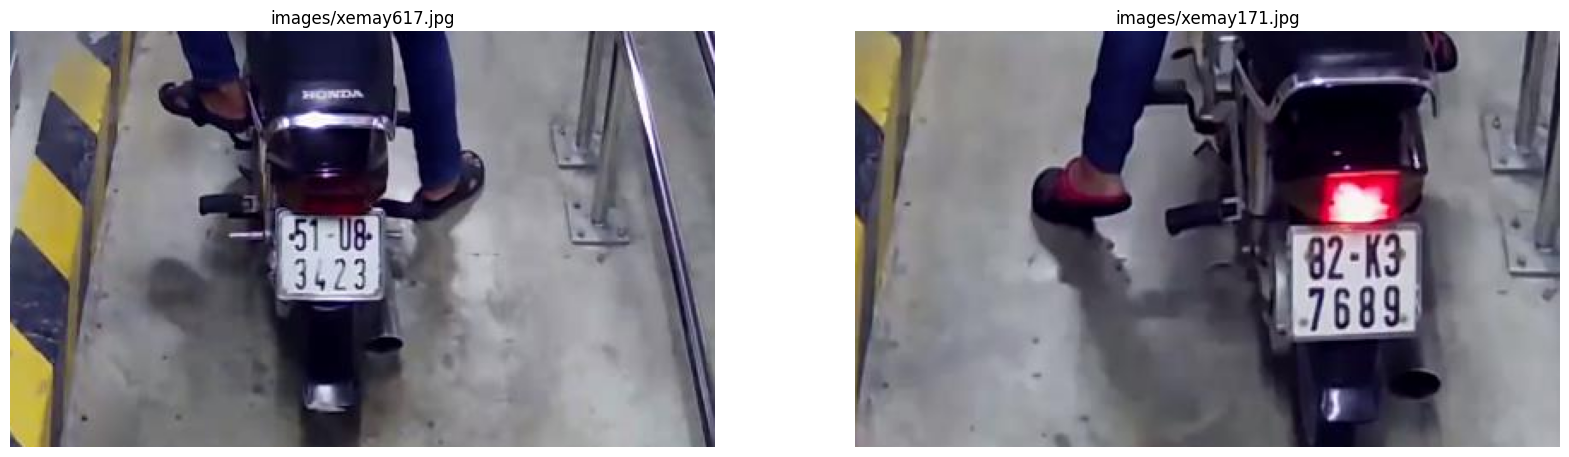

In [5]:
img.subplot_images(images, title=lambda _, i: images_path[i])

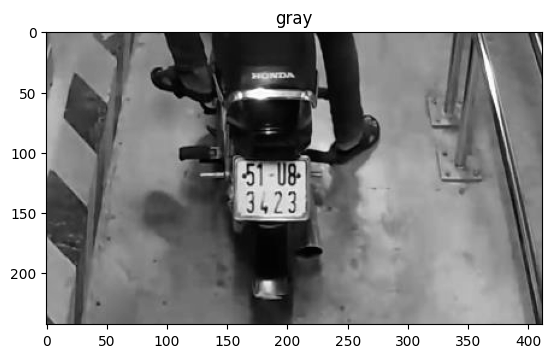

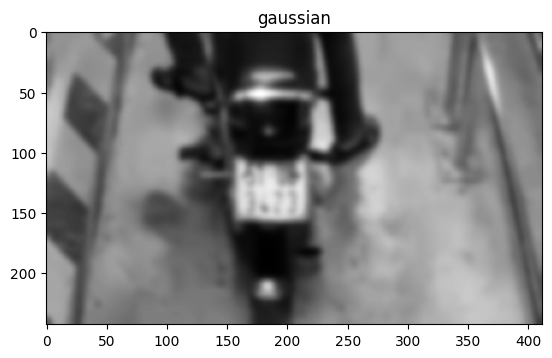

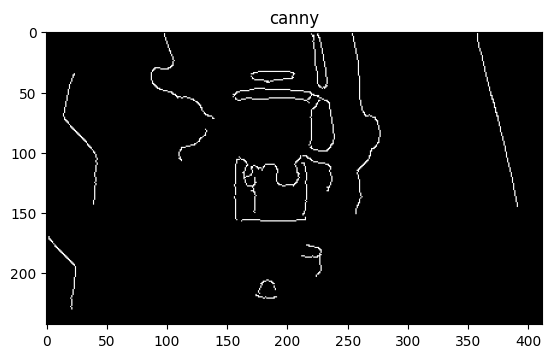

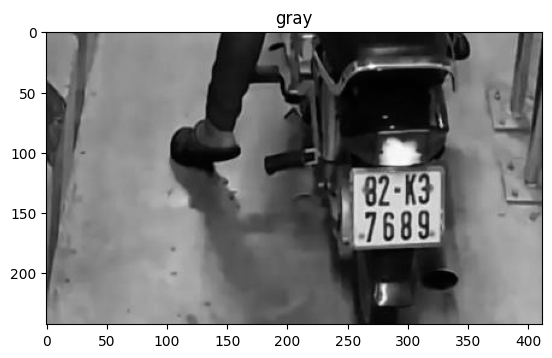

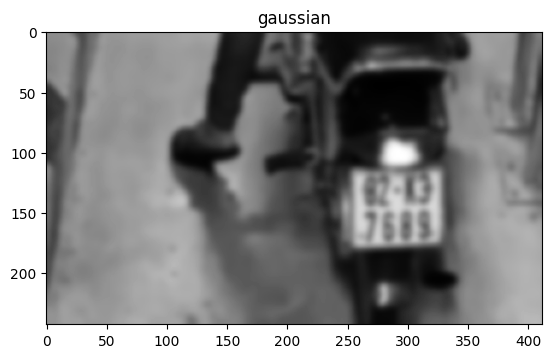

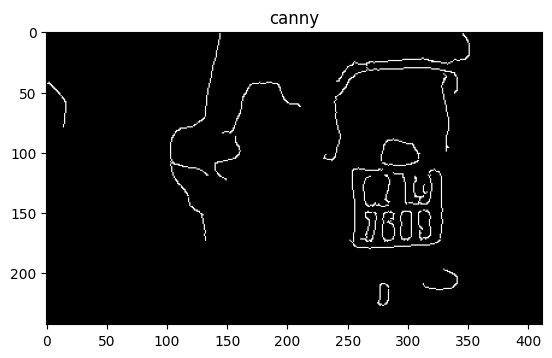

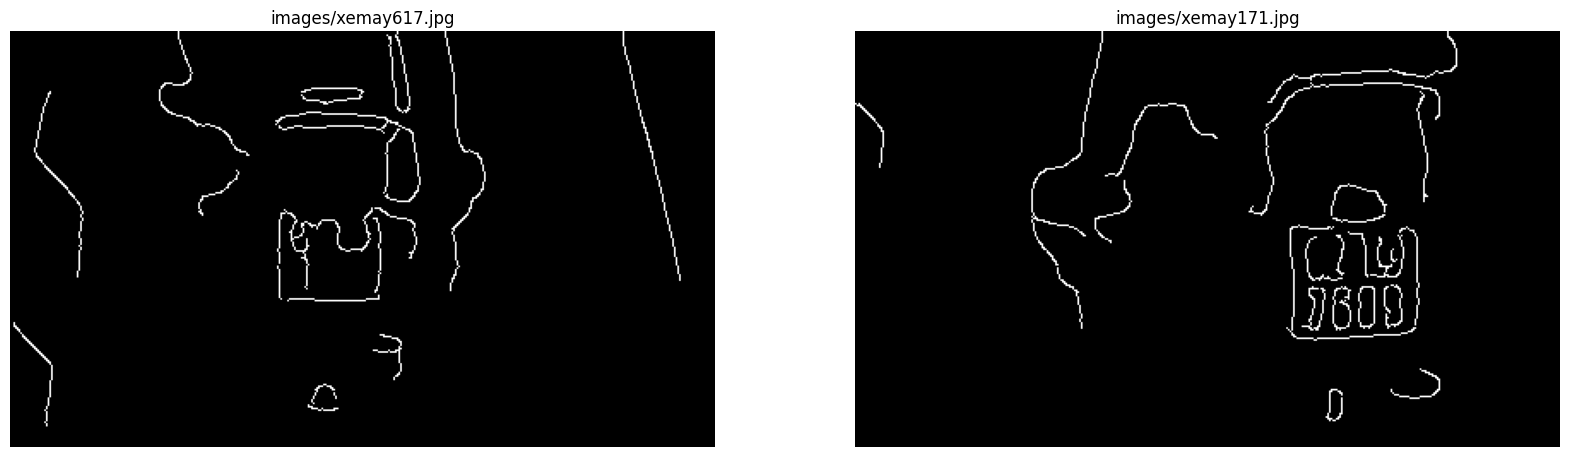

In [6]:
def select_white(image: cv2.Mat) -> cv2.Mat:
    # Convert to HSV color space
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img.show(gray, "gray", cmap="gray")

    # gaussian filter to remove noise
    cv2.GaussianBlur(gray, (15, 15), 0, gray)
    img.show(gray, "gaussian", cmap="gray")

    # sobel
    # sobelx = cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0, ksize=5)
    # img.show(sobelx, "sobel", cmap="gray")
    # sobely = cv2.Sobel(gray, cv2.CV_64F, dx=0, dy=1, ksize=5)
    # img.show(sobely, "sobel", cmap="gray")
    # sobelxy = cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=1, ksize=5)
    # img.show(sobelxy, "sobel", cmap="gray")

    # laplacian
    # laplacian = cv2.Laplacian(gray, cv2.CV_64F, ksize=5)
    # img.show(laplacian, "laplacian", cmap="gray")
    # laplacian = cv2.normalize(laplacian, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # laplacian = cv2.adaptiveThreshold(laplacian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # img.show(laplacian, "laplacian", cmap="gray")

    # in range laplacian
    # laplacian = cv2.normalize(laplacian, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # laplacian = cv2.inRange(laplacian, 0, 110)
    # img.show(laplacian, "laplacian", cmap="gray")

    # canny
    canny = cv2.Canny(gray, 50, 150)
    img.show(canny, "canny", cmap="gray")

    return canny

processed_images = [select_white(image) for image in images]

img.subplot_images(processed_images, title=lambda _, i: images_path[i], cmap="gray")

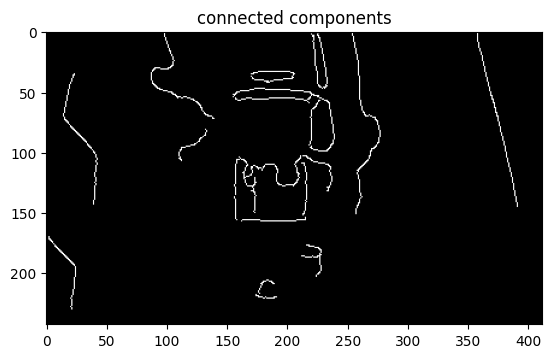

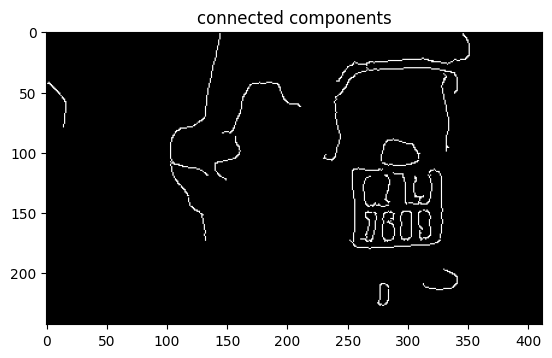

In [7]:
def detect_connected_components(image: cv2.Mat) -> Tuple[List[cv2.Mat], List[Tuple[int, int, int, int]]]:
    # find connected components
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)

    # connected components
    sizes = stats[1:, -1]
    nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    min_size = 20

    # your answer image
    img2 = np.zeros((output.shape))
    # for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255

    img.show(img2, "connected components", cmap="gray")

    # convert to 8UC1

    img2 = img2.astype(np.uint8)

    return img2, stats

connected_components = [detect_connected_components(image)[0] for image in processed_images]

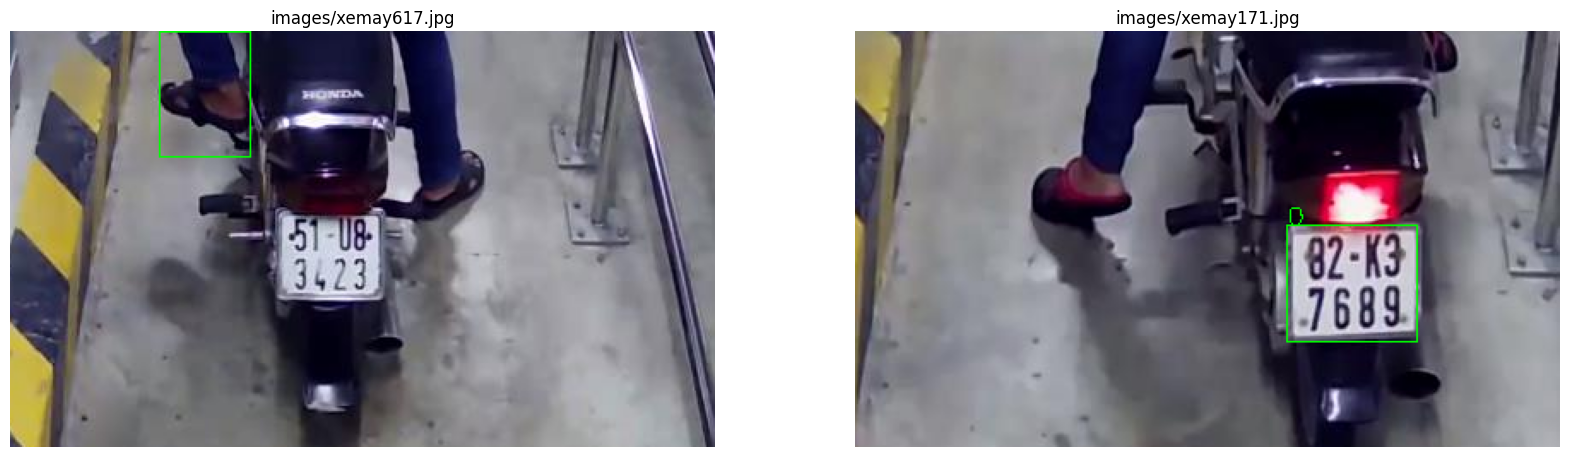

In [8]:
def detect_plate(image: cv2.Mat):
    all_contours, hierarchy = cv2.findContours(
        image=image,
        mode=cv2.RETR_TREE,
        method=cv2.CHAIN_APPROX_SIMPLE
    )

    def is_plate(contour):
        # Get the bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)

        ratio = float(w) / h
        area = w * h

        # Check if the contour is a plate
        return (
            0.5 <= ratio <= 1.5 and
            50 <= w <= 100 and
            50 <= h <= 100
        )

    # Filter the contours
    contours = list(filter(is_plate, all_contours))

    # remove the contours that are inside other contours
    def is_inside(contour):
        x, y, w, h = cv2.boundingRect(contour)
        for other_contour in contours:
            x2, y2, w2, h2 = cv2.boundingRect(other_contour)
            if x > x2 and y > y2 and x+w < x2+w2 and y+h < y2+h2:
                return True
        return False
    
    contours = list(filter(lambda contour: not is_inside(contour), contours))

    return contours, all_contours

def draw_regions(image: cv2.Mat, regions, color=(0, 255, 0), thickness=2, label: Callable[[int], str] = None):
    # Draw the regions on the original image
    for i, region in enumerate(regions):
        x, y, w, h = cv2.boundingRect(region)
        cv2.rectangle(image, (x, y), (x+w, y+h), color=color, thickness=thickness)

        if label is not None:
            cv2.putText(image, label(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color=color, thickness=thickness)

    return image

drawn_images: List[cv2.Mat] = []
cropped_images: List[cv2.Mat] = []
for i, image in enumerate(connected_components):
    regions, all_regions = detect_plate(image)

    # img_i = draw_regions(images[i], all_regions, color=(255, 0, 0), thickness=2)
    img_i = draw_regions(images[i].copy(), regions, thickness=1, label=lambda z: str(z))

    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        cropped_images.append(images[i][y:y+h, x:x+w])

    drawn_images.append(img_i)

img.subplot_images(drawn_images, title=lambda _, i: images_path[i])

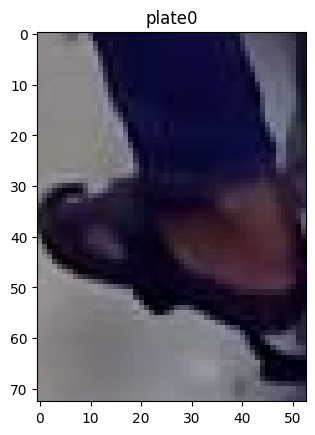

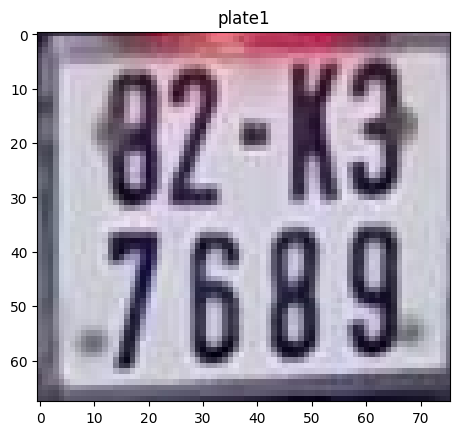

In [9]:
for i, image in enumerate(cropped_images):
    img.show(image, "plate"+str(i), cmap="gray")

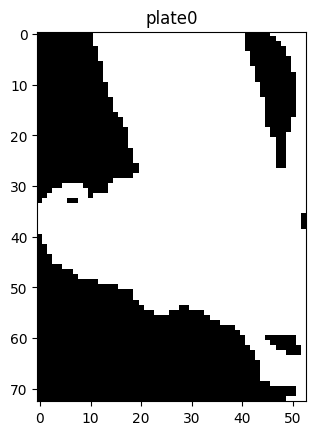

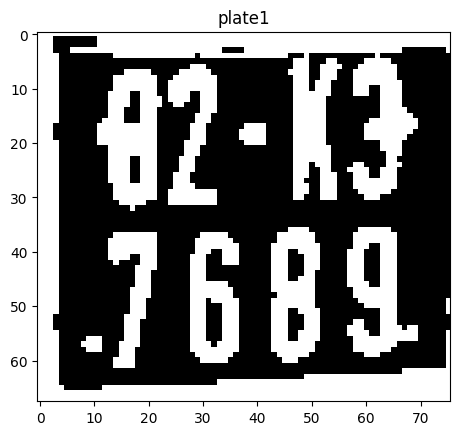

In [10]:
def binarize(image: cv2.Mat) -> cv2.Mat:
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # binarize
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    return cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

binarized_images = [binarize(image) for image in cropped_images]

for i, image in enumerate(binarized_images):
    img.show(image, "plate"+str(i), cmap="gray")

### Split plates into 2 lines

The model that we will use works on single text-line detection only, so we have to split the plates into 2 singles lines.
For finding where to split the plate, we use a "signature" method. First, we define some margin to not take the borders of the image in account, then we just have to search for the first row that only contains black pixels. If we find it, we split the plate in 2 at this row. If we don't find it, we just split at the row with the most black pixels. 

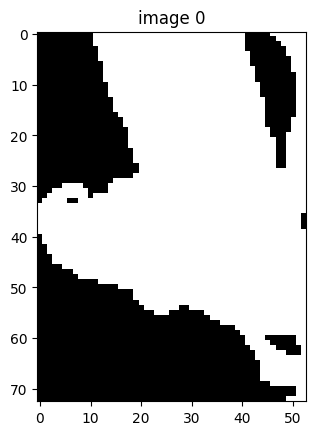

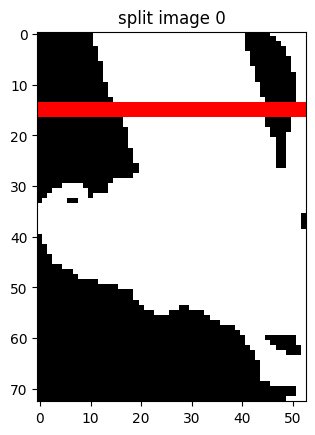

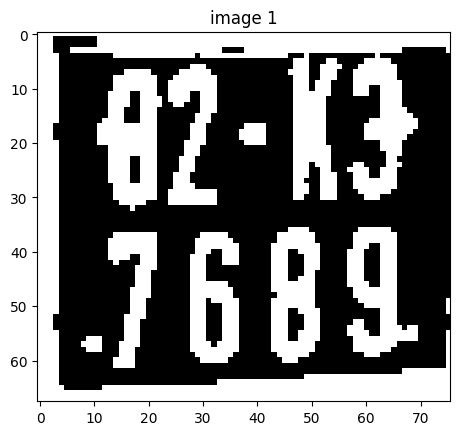

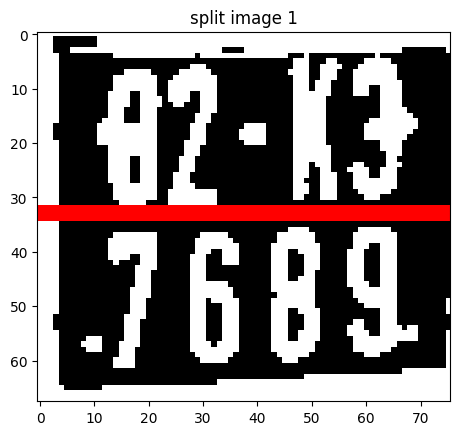

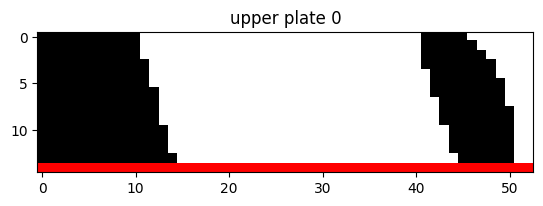

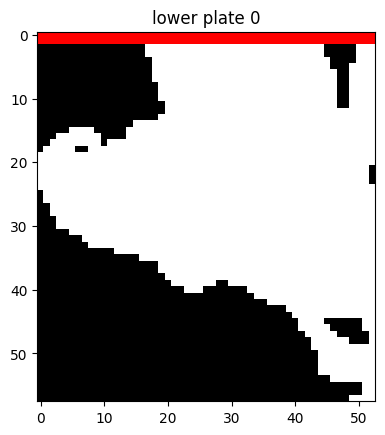

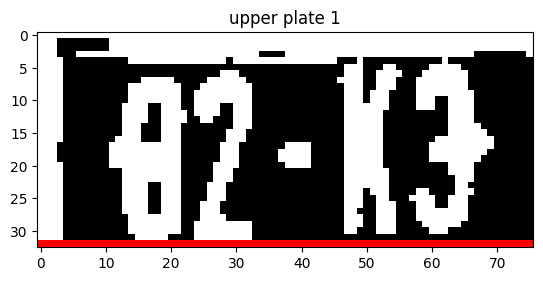

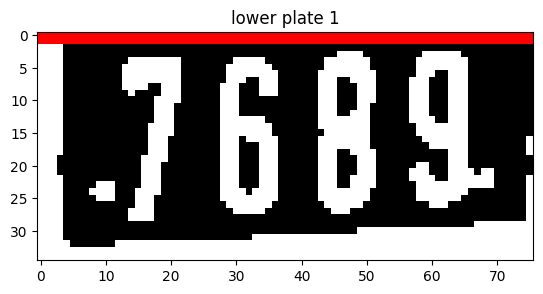

In [11]:
upper_plates = []
lower_plates = []


for image, i in zip(binarized_images, range(len(binarized_images))):
    img.show(image, "image " + str(i), cmap="gray")
    upper_plate, lower_plate, split_image = plates.Plate.split_plate(image)
    upper_plates.append(upper_plate)
    lower_plates.append(lower_plate)
    img.show(split_image, "split image " + str(i), cmap="gray")


if len(upper_plates) != len(lower_plates):
    print("ERROR: the number of upper plates does not match the number of lower plates")

for i, (upper, lower) in enumerate(zip(upper_plates, lower_plates)):
    img.show(upper, "upper plate " + str(i), cmap="gray")
    img.show(lower, "lower plate " + str(i), cmap="gray")


# Model 

In [12]:
# using TrOCR model from microsoft
# ref : https://huggingface.co/microsoft/trocr-base-printed

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Detection

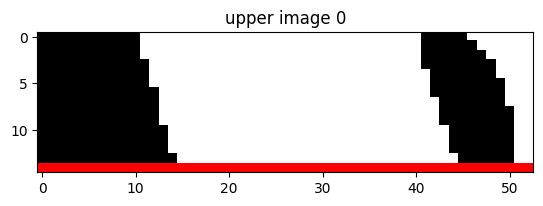

['1']


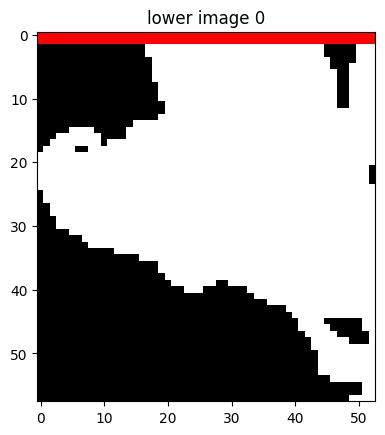

['2']


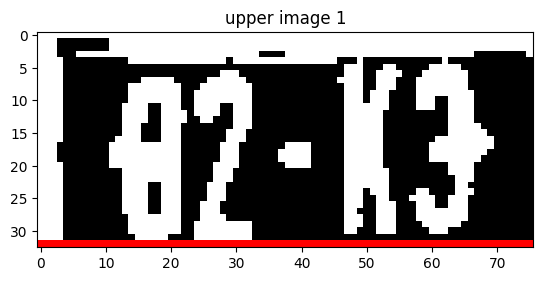

['02-K@']


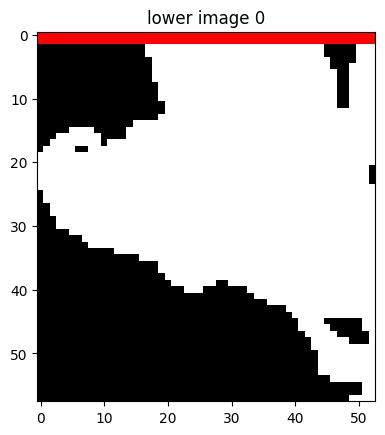

['2']


In [13]:
def model_process(image: cv2.Mat):
    # convert to PIL image
    pil_image = Image.fromarray(image)

    # model process
    inputs = processor(pil_image, return_tensors="pt", padding=True)
    outputs = model.generate(**inputs, max_new_tokens=30)
    return processor.batch_decode(outputs, skip_special_tokens=True)


for image, i in zip(upper_plates, range(len(upper_plates))):
    img.show(image, "upper image " + str(i), cmap="gray")
    print(model_process(image))

    image, i = next(zip(lower_plates, range(len(lower_plates))))
    img.show(image, "lower image " + str(i), cmap="gray")
    print(model_process(image))